In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import utils
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from tqdm import tqdm 
import warnings

In [3]:
warnings.filterwarnings('ignore')

In [4]:
# Number of clusters (excl. outliers)
k = 4

# Points per cluster (excl. outliers)
n = [500] * k

# Number of dimensions
d = 100

# Number of outliers
o = 50

# Cluster sizes
cluster_sizes = n + [o]

# Total clusters
k_total = k + (1 if o > 0 else 0)

In [5]:
alpha = 5

x = np.empty((0, d))
# C1 = first half 0, second half 1
half = np.zeros((1, ((3 * d) // 5))) + 0.1
half2 = np.zeros((1, d - ((3 * d) // 5))) + 1.1
x = np.vstack((x, np.hstack((half, half2))))
# C2 = first half 0.25, second half 0.75
half = np.zeros((1, d // 2)) + 0.25
half2 = np.zeros((1, d // 2)) + 0.75
x = np.vstack((x, np.hstack((half, half2))))
# C3 = first half 1, second half 0
half = np.zeros((1, d // 2)) + 1
half2 = np.zeros((1, d // 2))
x = np.vstack((x, np.hstack((half, half2))))
# C4 = first third 0.8, second third 0.2, last third 0.6
one = np.zeros((1, d//3)) + 0.8 
two = np.zeros((1, d//3)) + 0.2
three = np.zeros((1, (d - 2*(d//3)))) + 0.6
x = np.vstack((x, np.hstack((one, two, three))))

x = x * alpha

assert x.shape == (k, d)
assert np.linalg.matrix_rank(x) == k

In [6]:
def generate_points(x, d, n, k, noise_lower, noise_upper, p=0.3): 
    Y = np.zeros((0, d))
    for i in range(k): 
        for j in range(n[i]):    
            m = np.random.uniform(noise_lower, noise_upper)
            noise = np.random.choice([m, 0, -m], size=(1, d), p=[(1-p)/2., p, (1-p)/2.])
            point = x[i] + noise
            Y = np.vstack((Y, point))
    
    return Y

In [7]:
def generate_outliers(o, cluster_sizes, Y): 
    for i in range(o): 
        clusters = np.random.choice(range(len(cluster_sizes) - 1), size=2, replace=False)
        weight = np.random.uniform(0.5, 0.7)
        sample = [
            Y[np.random.randint(sum(cluster_sizes[:clusters[0]]), sum(cluster_sizes[:clusters[0]+1]))],
            Y[np.random.randint(sum(cluster_sizes[:clusters[1]]), sum(cluster_sizes[:clusters[1]+1]))]
        ]
        point = (sample[0] * weight) + (sample[1] * (1 - weight))
        Y = np.vstack((Y, point))
    
    return Y 


In [8]:
results = []
noise_levels = [(0.01, 0.1), (0.1, 0.3), (0.3, 0.5), (0.5, 0.7), (0.7, 1), (1, 1.5), (1.5, 2), (2, 2.5), (2.5, 3), (3, 4), (4, 5), (5, 7), (7, 9)]
pca_dim = 4

for low, high in tqdm(noise_levels): 
    Y = generate_points(x, d, n, k, low, high) 
    Y = generate_outliers(o, cluster_sizes, Y)

    D_pre = utils.get_distance_matrix(Y)

    pca = PCA(n_components=pca_dim)
    Y_post = pca.fit_transform(Y)
    D = utils.get_distance_matrix(Y_post)

    C = D_pre / D
    np.nan_to_num(C, copy=False, nan=0.0)
    cgraph = utils.compression_grouping(C, cluster_sizes)

    comp_var = [0] * len(C)
    for i in range(len(C)): 
        # comp_var[i] = np.var(C[i])
        comp_var[i] = utils.var(C[i], 2)
    combined_var = [(True if i >= sum(n) else False, comp_var[i]) for i in range(len(C))]
    combined_var.sort(key=lambda x: x[1])

    before = []
    count = 0
    for out, _ in combined_var: 
        if out: 
            before.append(count)
        else: 
            count += 1
    
    disc = np.unique(before, return_counts=True)
    num_zero = disc[1][0] if disc[0][0] == 0 else 0 
    eigen_ratio = pca.explained_variance_[2] / pca.explained_variance_[3]

    results.append((cgraph, num_zero, eigen_ratio))

  0%|          | 0/13 [00:00<?, ?it/s]

100%|██████████| 13/13 [01:18<00:00,  6.02s/it]


In [9]:
for cgraph, num_zero, eigen_ratio in results: 
    print(num_zero, eigen_ratio)

50 4171.537024125303
50 381.99912728922936
50 110.4773662583466
50 51.14102236397587
50 24.910936563868525
50 11.761296950673099
44 6.65926195368675
38 4.19329399999121
29 3.1305558498306936
7 2.157333821407515
1 1.6073973504272983
0 1.2907693748033815
0 1.0723665943606882


100%|██████████| 13/13 [00:37<00:00,  2.86s/it]


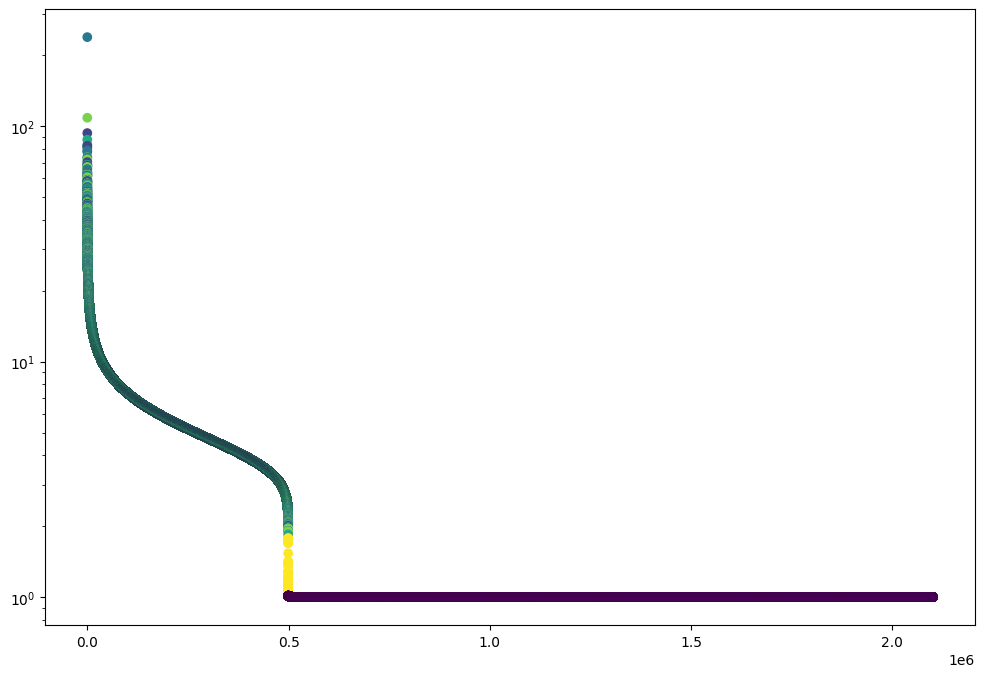

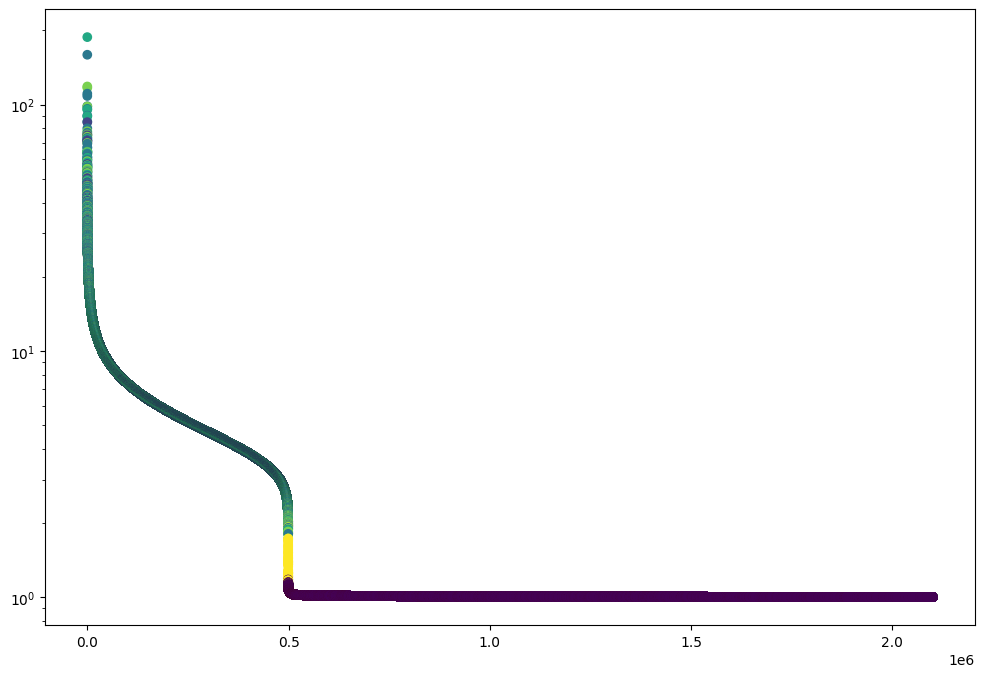

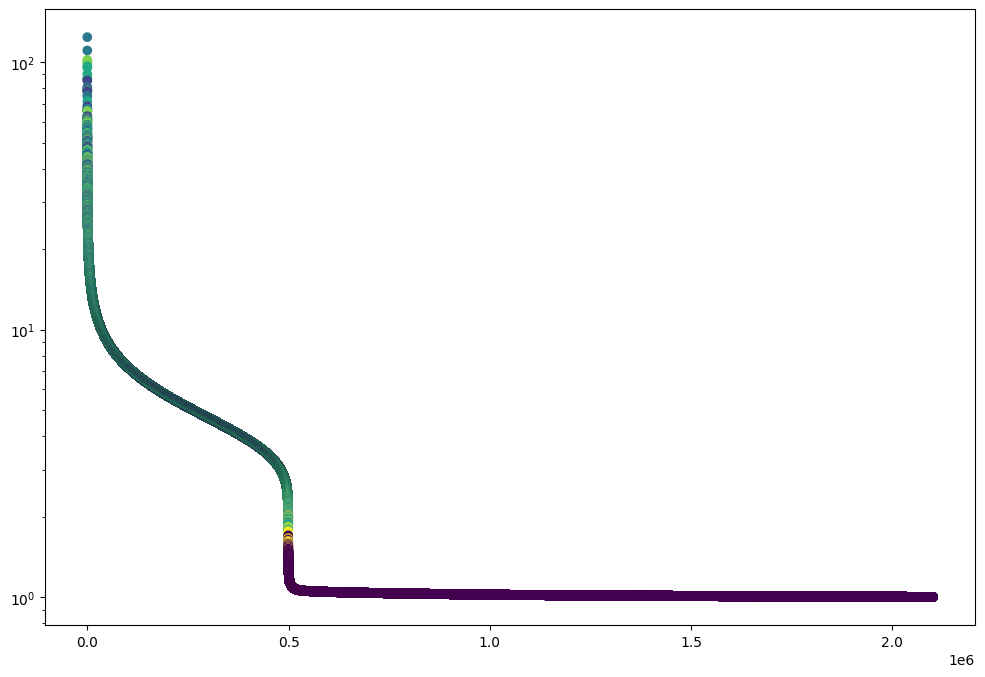

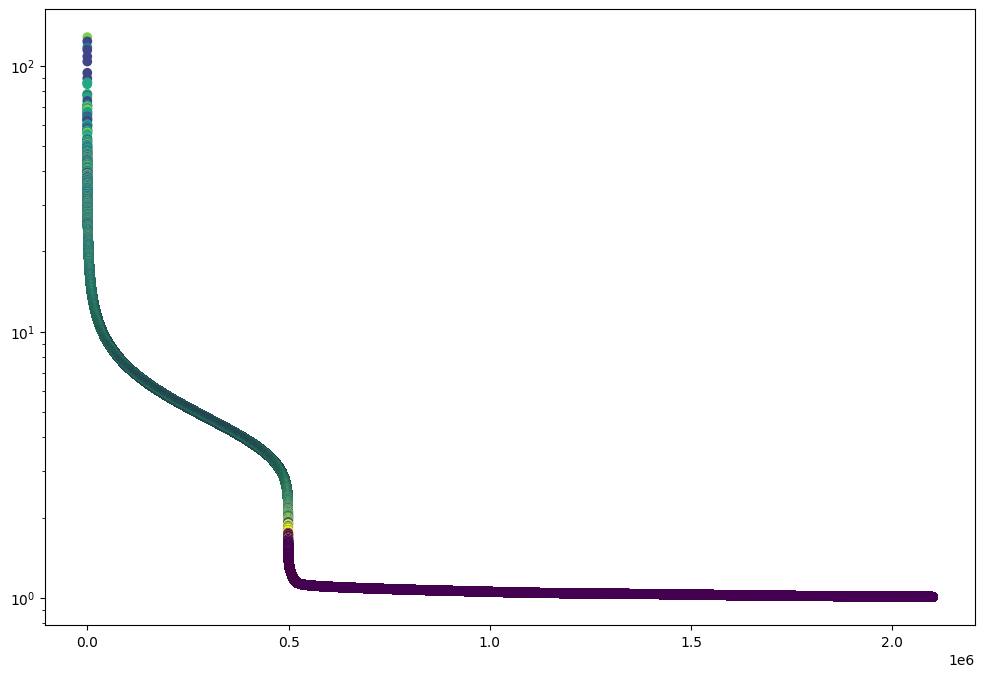

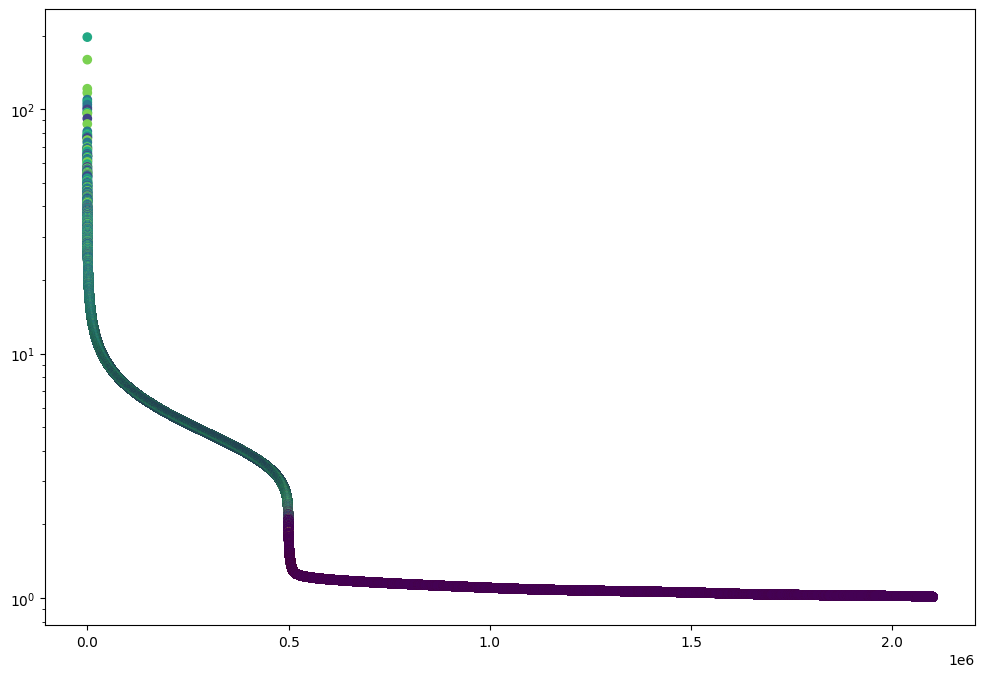

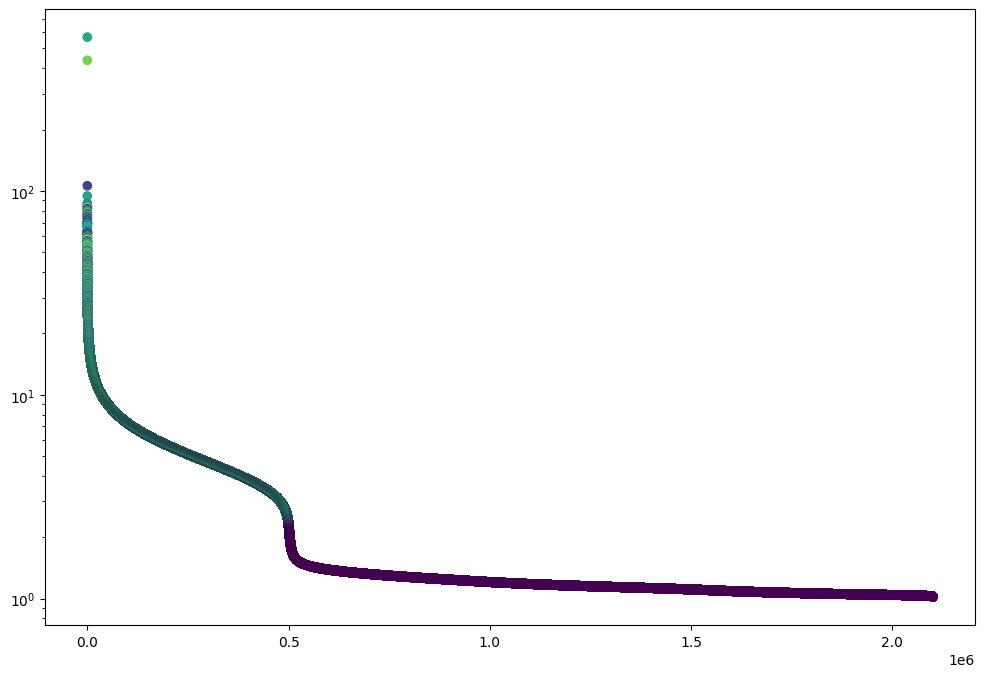

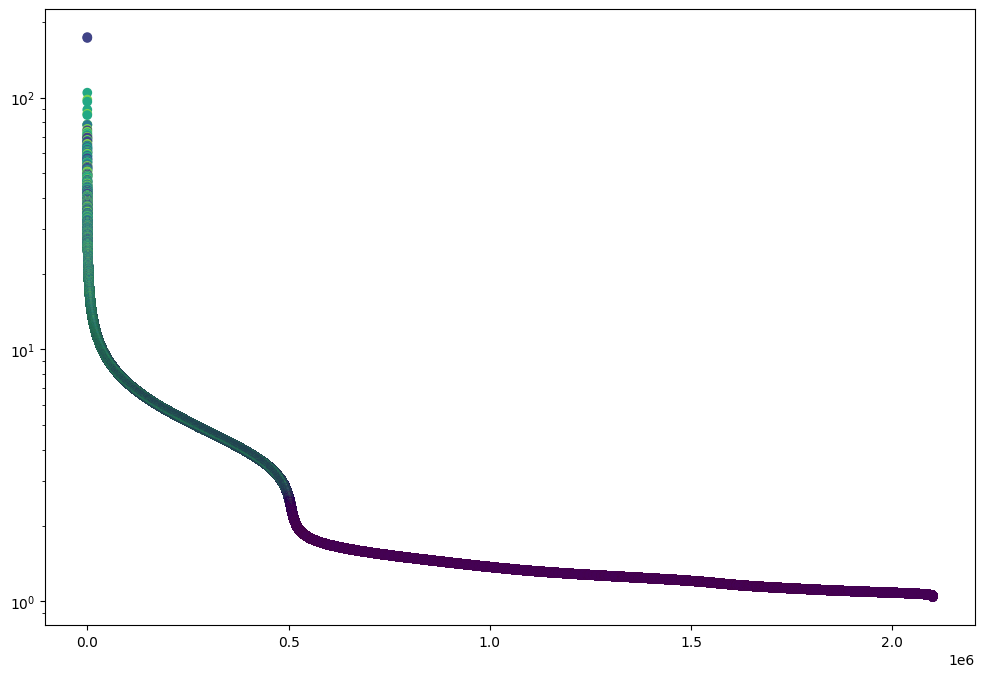

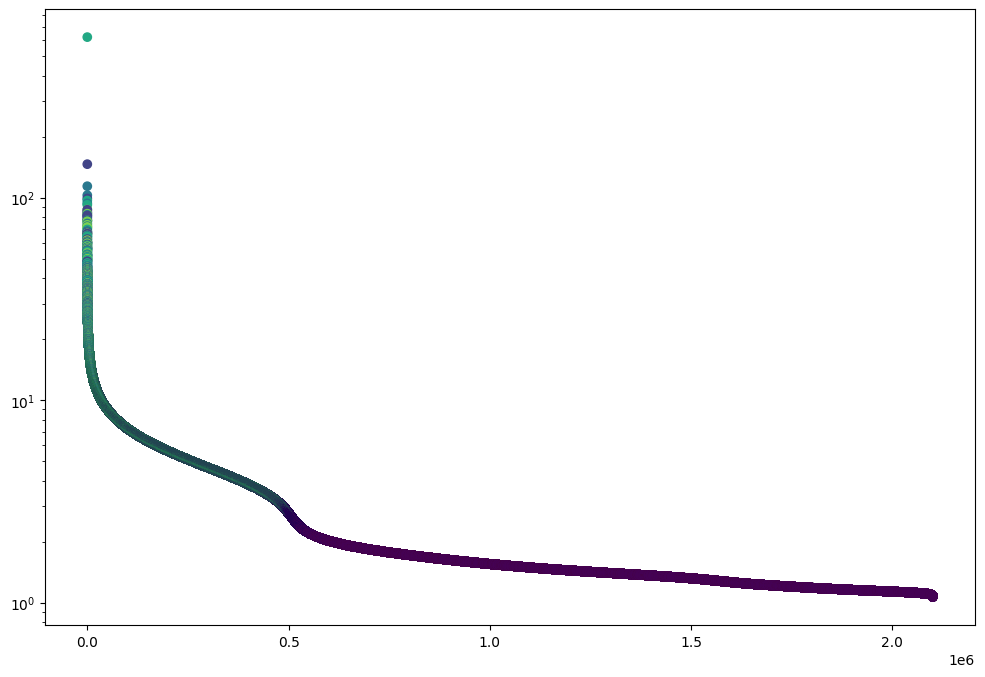

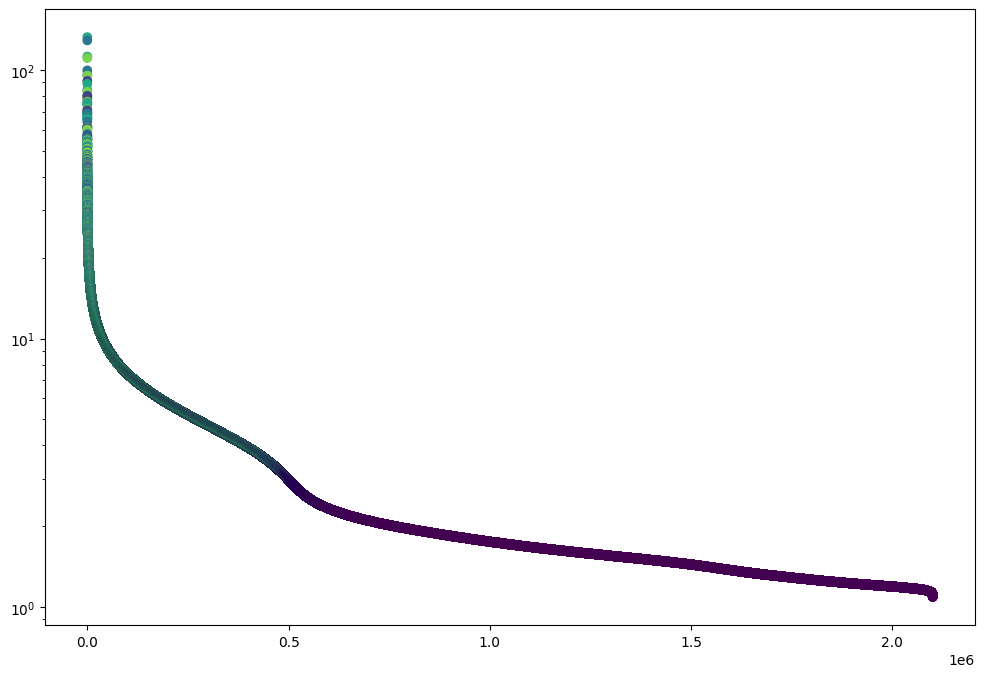

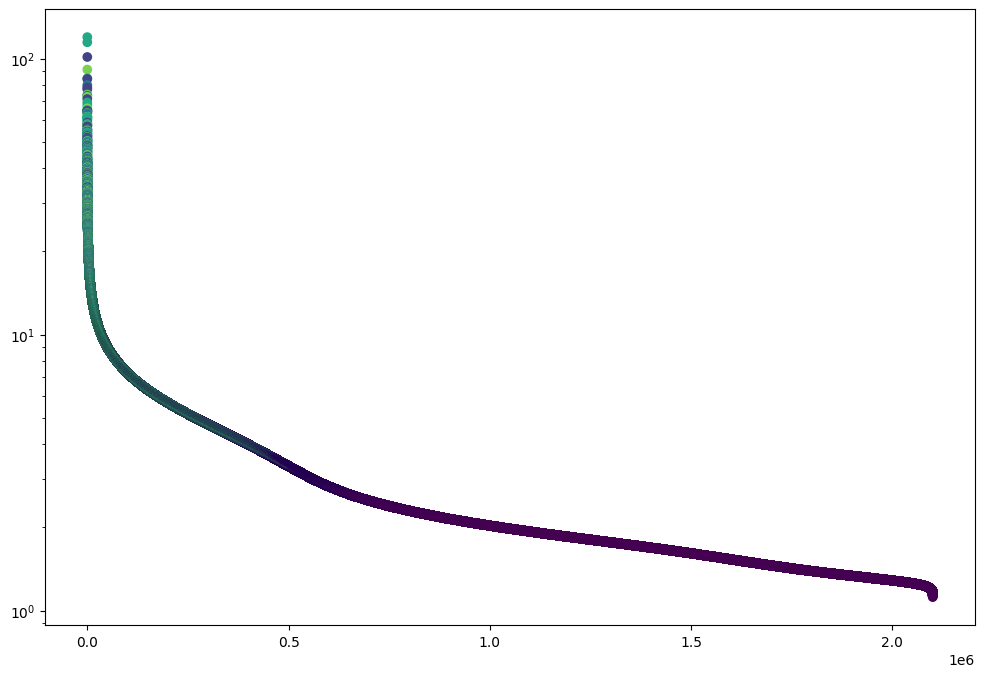

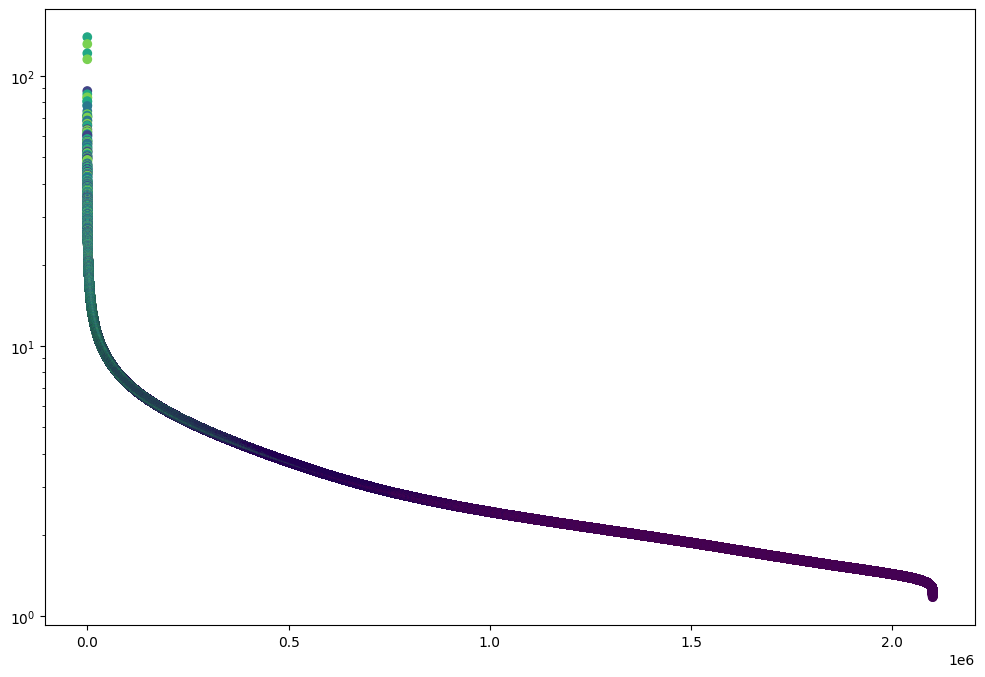

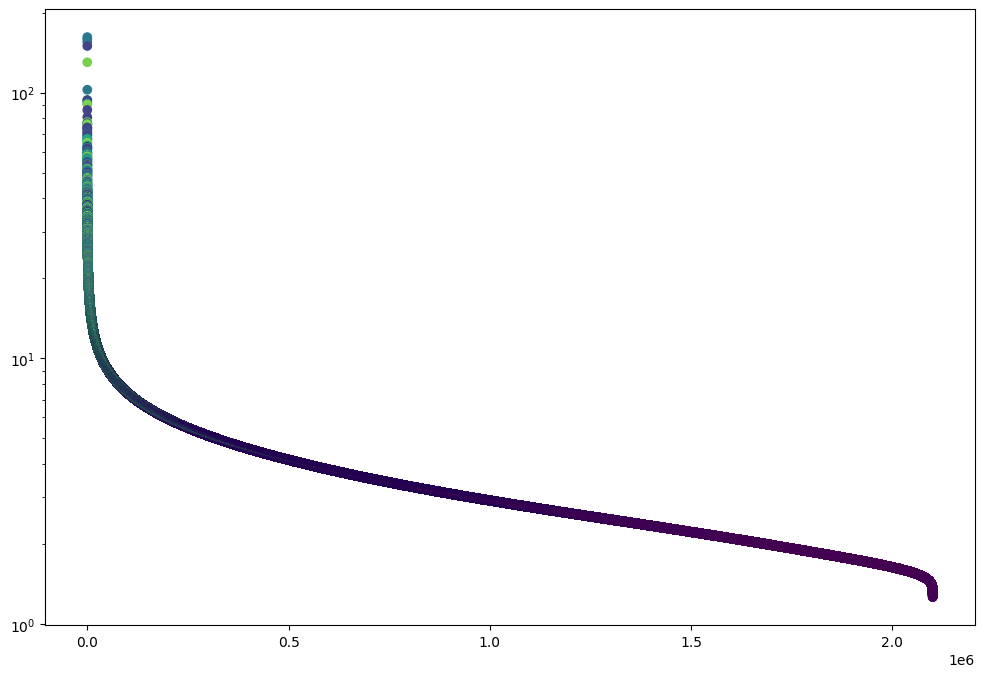

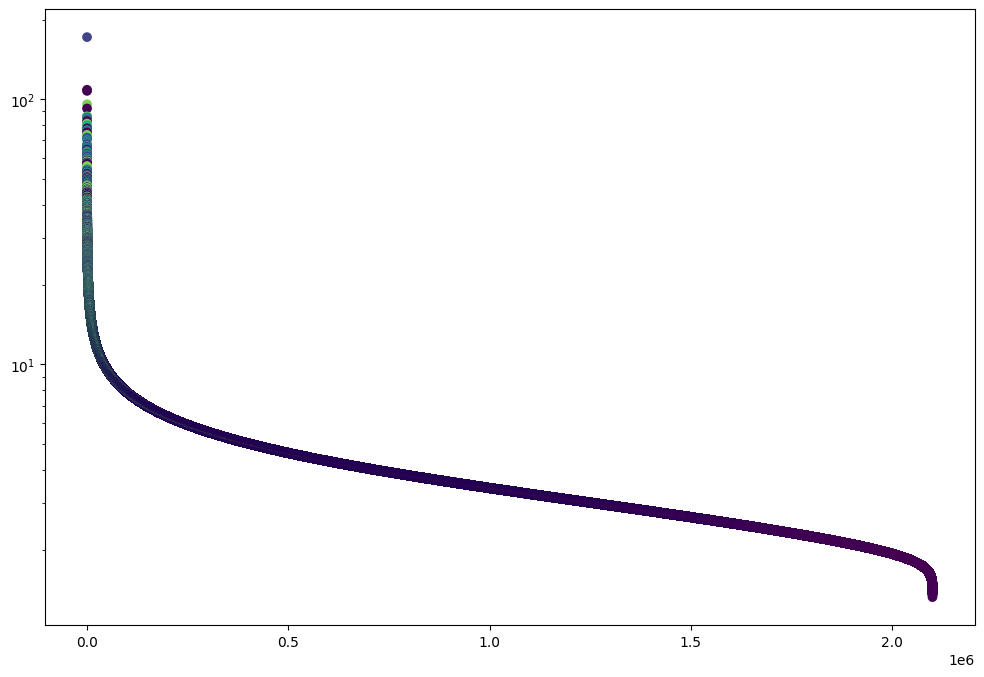

In [11]:
for cgraph, _, __ in tqdm(results): 
    cgraph = cgraph[::-1]
    index = list(range(0, len(cgraph)))

    plt.figure(figsize=(12,8))
    # Plot values from test colored if inter or intra cluster, x axis is index
    plt.scatter(index, cgraph[index, 0], c=cgraph[index, 1])
    # Set vertical scale to be logarithmic
    plt.yscale('log')